In [1]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.Rl_function_approximation import approach_approx_Q, approach_approx_V
from IPython.display import clear_output
clear_output()
#from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

# Eligibility Traces ($\lambda$)
*   n-step methods delay evaluation for n steps. We can call it _backward view_. In extreme they converge into Monte-Carlo method
    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n \hat v_{t+n -1}(S_{t+n}, \vec{w}_{t+n-1})$$
*   One may construct a target by creating a _compound return_, which is a weighted sum (average) of different n-step returns.

    For example an average of 2-step and 4-step return:
    $$\frac{1}{2} G_{t:t+2} + \frac{1}{2} G_{t:t+4}$$
    We may ask for sum of weights to be 1, as to signify the importance of each n-step return
*   We can sum all 'partial' returns $G_{t:t+p}$ from sequence on rewards of $n$ steps with 'decaying' weights that are proportional to $\lambda^{n-1}$ $(\lambda \in [0,1])$

    For these weights to work, we have to normalize each by $(1-\lambda)$
    $$\boxed{G_n^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n}} $$
    ***
    Weight normalization:
    $$\sum_{n=1}^\infty \lambda^{n-1}  = \lambda^0 + \lambda^1+\dots = \sum_{n=0}^\infty \lambda^{n}$$
    Geometric series:
    $$\sum_{n=0}^\infty a r^n = \frac{a}{1-r} \rightarrow \sum_{n=1}^\infty \lambda^{n-1} = \sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot$$
    $$\sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot \bigg| (1- \lambda)  \longrightarrow \boxed{(1- \lambda) \sum_{n=1}^\infty \lambda^{n-1}= 1}$$
    ***
*   $\lambda$ methods work in reverse 

On termination step $T$:
$$t+n_T = T \rightarrow n_T = T - t$$
$$\lambda^{n_T-1} G_{t:t+n_T}  = \lambda^{T- t -1} G_{t:T} = \lambda^{T- t -1} G_t $$
We can split $G_t^\lambda $ into two terms
$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n} = (1-\lambda)\sum_{n=1}^{n_T - 1 = (T - t) - 1}\lambda^{n-1} G_{t:t+n} + (1-\lambda)\sum_{n= n_T = T - t}^\infty \lambda^{n-1} G_{t:t+n}$$
*   _Im not sure what happens to second term past termination state. $ G_{t:T} = G_{t:T + 1} = G_t$?_
*   _if we terminate sum past $T$ then right term should be $(1-\lambda) \cdot \lambda^{T- t -1} G_t$. Why in the book its only $\lambda^{T- t -1} G_t$?_

Anyway, result in the book is:
$$\boxed{G_t^\lambda = (1-\lambda)\sum_{n=1}^{(T - t) - 1}\lambda^{n-1} G_{t:t+n} + \lambda^{T- t -1} G_t}$$
Which shows that in case of $\lambda = 1$
$$G_t^{\lambda = 1} = 0\cdot \sum_{n=1}^{(T - t) - 1}G_{t:t+n} + 1^{T-t-1} \cdot G_t = G_t$$
which i a Monte Carlo return. And if $\lambda = 0$
$$G_t^{\lambda=0} = 1\cdot [ 0^0 \cdot G_{t:t+1} + 0^1 \cdot G_{t:t+2} + \dots] + 0^{T-t-1} \cdot  G_t = G_{t:t+1} + 0 + \dots$$

so we see that extreme values of $\lambda$ change composite return to either TD(0) or MC returns:
*   $G_t^{\lambda = 1} = G_t$
*   $G_t^{\lambda = 0} = G_{t:t+1}$


# Semi-gradient TD($\lambda$) for estimating $\hat v \approx v_\pi$
Eligibility trace vector holds history visited states. 

Vectors shape is the same as the shape of f-n approximation parameters, each entries is relate to state or states.

$$ \boxed{\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + \nabla_w \hat v(S_t, \vec{w}_t)}$$

Expression has two parts:
1.  term $\nabla_w \hat v(S_t, \vec{w}_t)$ shows which v approximation parameters (might think which states) are relevant/active now. Assign these entries (~)non-zero values.

2. term $\gamma \lambda \vec{z}_{t-1}$ holds a history. Values of $z$ decay as $\lambda$ each iteration

Overall $z$ holds amplitudes of most 'active' parameters/states at current trajectories step.

function approximation weights are then updated using this history

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \vec{z}_{t}}$$
where $\delta_t$ is an (TD) error

$$\delta_t = R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) - \hat v(S_{t}, \vec{w}_t) $$

one can see, that this way updates to weights 'persist' through iterations.

if $\lambda = 0$, TD($\lambda$) weight update reduces to TD(0) approach _(not a naming coincidence)_:
$$\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \nabla_w \hat v(S_t, \vec{w}_t)$$

if $0 \lt \lambda \lt 1$ more states in trajectory 'take credit' for TD error

if $\lambda = 1$ Monte Carlo behavior is achieved and algorithm is named... TD(1)

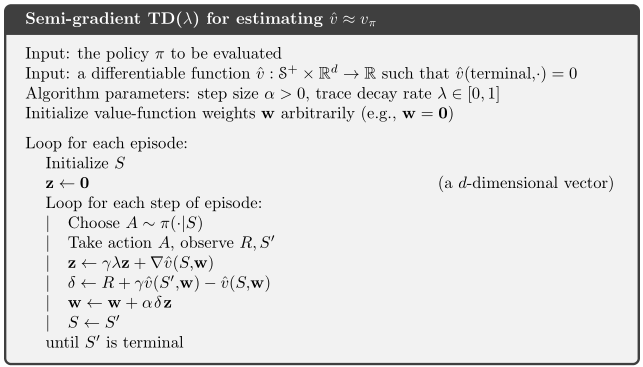

Remember
$$\nabla_{\vec{w}} \hat v(s, \vec{w}) = \vec{x}(s) $$
and if $\vec{x}(s)$ is __binary and one-hot__ vector encode then its a __binary mask__. 

If $\vec{x}(s)$ holds only __feature indices__, then we update __only according weights__ 
$$\{\vec{w}_i: i \in \vec{x}(s) \}$$

Same with eligibility traces $\vec{z}$.

Because case is overall discrete, thus __tabular__, then each state has its weight and we can implement policy by __directly changing the weights__.

In [29]:
class TD_Lambda(approach_approx_V):
    def __init__(self, env_name, eps, tile_params, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs):
        super().__init__(env_name, eps, tile_params, *args, **kwargs)
        self.states = []
        self.rewards = []
        self.ALPHA = ALPHA
        self.LAMBDA = LAMBDA
        self.GAMMA = GAMMA
        self.z = np.zeros_like(self.Wv)

    def update_z(self,state):
        self.z *= self.GAMMA*self.LAMBDA        # decay all features
        self.z[self.state_emb.Xs(state)] += 1   # boost active features

    def target(self, reward, state, state_next):
        return reward +  self.GAMMA *self.Vs(state_next) - self.Vs(state)

    def update_Wv(self, delta):
        self.Wv += self.ALPHA*delta*self.z  
        
def TD_Lambda_Loop(env: TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0  
        t = 0                 
        while True:
            At = env.sample_action(state)  
            state_next, reward, terminal = env.step(At)
            env.update_z(state)
            delta = env.target(reward,state, state_next)
            env.update_Wv(delta)
            state = state_next
            t += 1
            if terminal:
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)
                break
    return 
        

Modify policy that greedy action is everywhere to the right and at start to the top.

100%|██████████| 2000/2000 [00:32<00:00, 62.29it/s, T=121, env_iters=2000, eps=0.4]


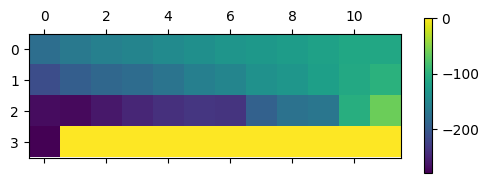

In [31]:
env_TD_Lambda = TD_Lambda("CliffWalking-v0", eps=0.4, tile_params=None)
env_TD_Lambda.policy += 1
env_TD_Lambda.policy[36:] = 0

TD_Lambda_Loop(env_TD_Lambda, N = 2000)
c = plt.matshow(env_TD_Lambda.Wv.reshape(4,12))
plt.colorbar(c)

# True online TD($\lambda$) for estiamating $\vec{w}^T \vec{x} \approx v_\pi$
Well... Roughly speaking we want update weights in online manner, but still want to do n-step updates. We can unfold n-step updates and as new information is available re-calculate/update old calculation with estimator using most recent weights...

$$\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + (1 - \alpha \gamma \lambda \vec{z}_{t-1}^T \vec{x}_t)\vec{x}_t$$

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \delta_t \vec{z}_{t} + \alpha(\vec{w}_{t}^T \vec{x}_t - \vec{w}_{t-1}^T\vec{x}_t)\cdot (\vec{z}_{t}-\vec{x}_{t})$$

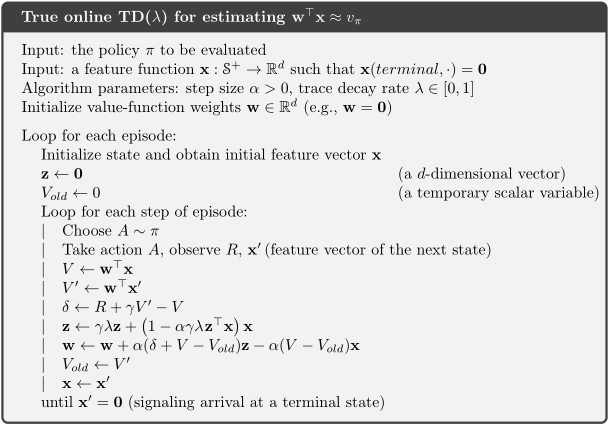

Approach of terminating at $\vec{x} = \vec{0}$ is probably means that $\vec{w}^T \vec{x} = 0$, so its understandable. Although there are other non-zero terms remaining.

In [39]:
class True_online_TD_Lambda(approach_approx_V):
    def __init__(self, env_name, eps, tile_params, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs):
        super().__init__(env_name, eps, tile_params, *args, **kwargs)
        self.rewards = []
        self.ALPHA = ALPHA
        self.LAMBDA = LAMBDA
        self.GAMMA = GAMMA
        self.z = np.zeros_like(self.Wv)

        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA
        self.V, self.Vp = 0,0
        self.delta      = 0
        self.states,   self.rewards = [], []

    def update_z(self,state):
        active_features = self.state_emb.Xs(state)
        zTx = np.sum(self.z[active_features]) #np.dot(self.z, self.Xs(state))
        self.z  = self.GL * self.z                       # decay all features
        self.z[active_features] += (1 - self.AGL*zTx)    # boost active features

    def target(self, reward, state, state_next):
        self.V  = self.Vs(state)
        self.Vp = self.Vs(state_next)
        self.delta = reward + self.GAMMA *self.Vp - self.V

    def update_Wv(self, state, V_old):
        self.Wv += self.ALPHA*(self.delta + self.V - V_old)*self.z 
        active_features = self.state_emb.Xs(state)
        self.Wv[active_features] -= self.ALPHA*(self.V - V_old)
        

def True_online_TD_Lambda_Loop(env: True_online_TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0  
        V_old = 0 
        t = 0                
        while True:
            At = env.sample_action(state)  
            state_next, reward, terminal = env.step(At)
            env.target(reward, state, state_next)
            env.update_z(state)
            env.update_Wv(state, V_old)
            V_old = env.Vp
            state = state_next
            t += 1
            if terminal:
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)
                break
    return 

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 2000/2000 [00:34<00:00, 57.45it/s, T=34, env_iters=2000, eps=0.4] 


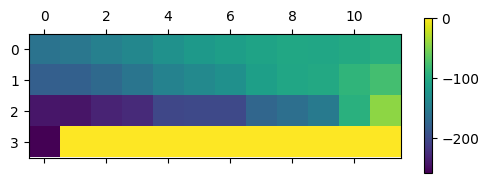

In [40]:
env_True_online_TD_Lambda = True_online_TD_Lambda("CliffWalking-v0", eps=0.4, tile_params=None)
env_True_online_TD_Lambda.policy += 1
env_True_online_TD_Lambda.policy[36:] = 0

True_online_TD_Lambda_Loop(env_True_online_TD_Lambda, N = 2000)
c = plt.matshow(env_True_online_TD_Lambda.Wv.reshape(4,12))
plt.colorbar(c)

# Sarsa($\lambda$) with binary features an lin f-n approx $q_\pi \approx \vec{w}^T\vec{x}$ or $q_\ast$

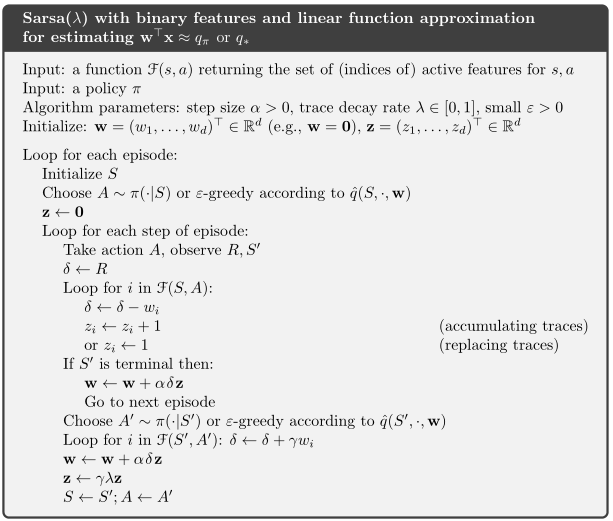

Regarding $\mathcal{F}(S,A)$ code segments. 

For linear approximation (using binary tabular and tile course coding), I've defined $\vec{x}(S)$ as $\mathcal{F}(S,A)$ by default.
$$\hat q(s,a, \vec{w}) = \sum_{i = 1}^d w_i x_i(s,a) = \sum_{i \in \mathcal{F}(S,A) = \vec{x}(S)} w_i $$

and $\delta \leftarrow \delta - w_i$ loop reduces to $\delta  = \delta - \hat q(s,a, \vec{w})$

$z_i \leftarrow z_i + 1$ loop also trivial

In [2]:
class SARSA_Lambda(approach_approx_Q):
    def __init__(self, env_name, eps, tile_params, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs):
        super().__init__(env_name, eps, tile_params, *args, **kwargs)
        self.ALPHA  = ALPHA
        self.LAMBDA = LAMBDA
        self.GAMMA  = GAMMA
        self.z      = np.zeros_like(self.Wq)
        self.GL     = self.GAMMA*LAMBDA
        self.AGL    = self.ALPHA*self.GAMMA

    def update_z(self):
        self.z  *= self.GL  # just decay

    def update_Wq(self, delta):
        self.Wq += self.ALPHA*delta*self.z

def SARSA_Lambda_Loop(env: SARSA_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state   =  env.reset()   
        action  =  env.sample_action(state)  
        env.z   *= 0  
        t       =  0
        while True:
            state_next, reward, terminal = env.step(action)
            delta = reward
            state_action = state + (action,)
            delta -= env.Qsa(state_action)
            active_features = env.state_emb.Xs(state_action)
            env.z[active_features] += 1
            if terminal: 
                env.Wq += env.ALPHA*delta*env.z
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)

                break
            action_next = env.sample_action(state_next)  
            delta += env.GAMMA*env.Qsa(state_next + (action_next,))

            env.update_Wq(delta)
            env.update_z()

            state   = state_next
            action  = action_next
            t += 1
    return

## Cliff Walking Sarsa($\lambda$) with binary features

100%|██████████| 2000/2000 [00:31<00:00, 64.36it/s, T=22, env_iters=2000, eps=0.4] 


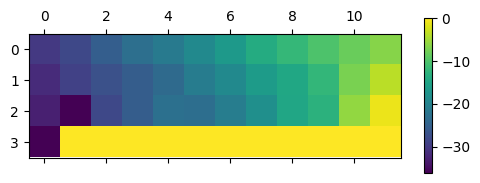

In [50]:
env_SARSA_Lambda= SARSA_Lambda("CliffWalking-v0", eps=0.4, tile_params=None)

SARSA_Lambda_Loop(env_SARSA_Lambda, N = 2000)
c = plt.matshow(env_SARSA_Lambda.Wq.reshape(4,12,4).max(-1))
plt.colorbar(c)

## Mountain Car Sarsa($\lambda$) with binary features

In [10]:
tp = (8, 40, 0.1)
env_SARSA_Lambda_MC = SARSA_Lambda('MountainCar-v0', eps = 0.1, tile_params = tp, GAMMA = 1, ALPHA = 1/2/tp[0])

In [11]:
SARSA_Lambda_Loop(env_SARSA_Lambda_MC, N = 1000)

100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s, T=142, env_iters=1000, eps=0.1]


In [5]:
def plot_Q_MC(env):
  low                 = env.env.observation_space.low
  high                = env.env.observation_space.high
  minmax_x, minmax_y  = np.vstack((low,high)).T
  x = np.linspace(*minmax_x, 50)
  y = np.linspace(*minmax_y, 50)

  z = np.zeros([len(x), len(y)])
  for i in range(len(x)):
    for j in range(len(y)):
      val = np.array([env.Qsa((x[i], y[j],a)) for a in env.actions]).max()
      z[i,j] = val #en.Qsa(2, (x[i], y[j]))
      
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 1, 1, projection='3d')
  X, Y = np.meshgrid(x, y)
  surf = ax.plot_surface(X, Y, -z.T, rstride=1, cstride=2, shade=False, cmap=None, linewidth=1, label='Approximation')
  surf.set_edgecolors(surf.to_rgba(surf._A))
  surf.set_facecolors("white")
  ax.view_init(elev=55., azim=-55)

  ax.grid(False)
  ax.set_xlabel('Car Position')
  ax.set_ylabel('Car Velocity');

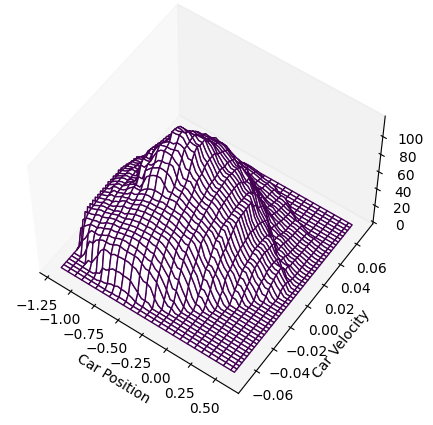

In [18]:
plot_Q_MC(env_SARSA_Lambda_MC)

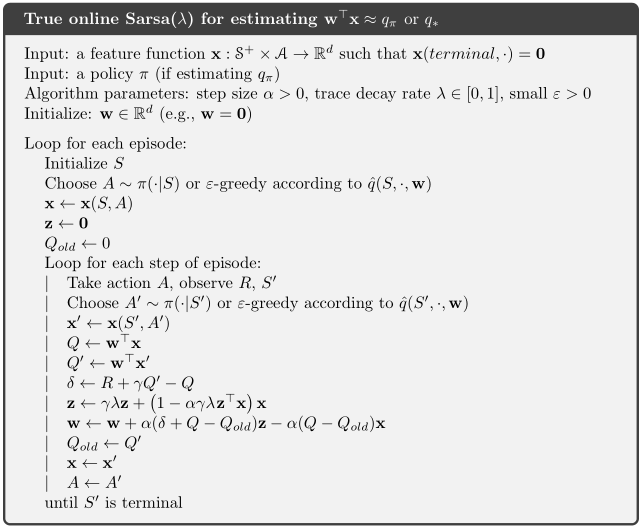

Too many re-used variables. Im implementing all the updates inside training loop.

In [26]:
class True_SARSA_Lambda(approach_approx_Q):
    def __init__(self, env_name, eps, tile_params, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs):
        super().__init__(env_name, eps, tile_params, *args, **kwargs)
        self.ALPHA = ALPHA
        self.LAMBDA = LAMBDA
        self.GAMMA = GAMMA
        self.z = np.zeros_like(self.Wq)

        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA

def True_SARSA_Lambda_Loop(env: True_SARSA_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()   
        action          = env.sample_action(state) 
        state_action    = state + (action,) 
        active_features = env.state_emb.Xs(state_action)
        env.z           *= 0  
        Q_old           = 0
        t               = 0
        while True:
            state_next, reward, terminal   = env.step(action)

            if terminal: 
                env.env_iters += 1
                tq_iter.set_postfix(eps=env.eps, T = t, env_iters = env.env_iters)
                break
            action_next             = env.sample_action(state_next)

            state_action_next       = state_next + (action_next,)
            active_features_next    = env.state_emb.Xs(state_action_next)
            Q                       = env.Qsa(state_action)
            Q_next                  = env.Qsa(state_action_next)
            delta                   = reward + env.GAMMA *Q_next - Q

            ztx                     = np.sum(env.z[active_features])
            env.z                   *= env.GL # all z's should decay
            env.z[active_features]  += (1 - env.AGL*ztx) 

            env.Wq                  += env.ALPHA*(delta + Q - Q_old)*env.z 
            env.Wq[active_features] -= env.ALPHA*(Q - Q_old)
            
            Q_old                   = Q_next
            active_features         = active_features_next
            action                  = action_next
            state_action            = state_action_next
            t                       += 1
    return 
tp = (8, 40, 0.1)
env_True_SARSA_Lambda_MC = True_SARSA_Lambda('MountainCar-v0', eps = 0.1, tile_params = tp,  ALPHA = 1/2/tp[0], LAMBDA=0.9, GAMMA = 1)


100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s, T=157, env_iters=1100, eps=0.1]


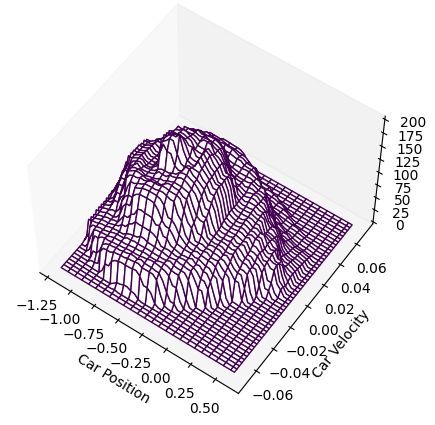

In [28]:
True_SARSA_Lambda_Loop(env_True_SARSA_Lambda_MC, N = 1000)
plot_Q_MC(env_True_SARSA_Lambda_MC)